<a href="https://colab.research.google.com/github/12lholt/MSAI349/blob/main/lead_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from captum.attr import *
import torch
import torch.nn as nn
import pandas as pd
from json import load
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Liberation Serif'
matplotlib.rcParams['font.size'] = 15.0

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
dataset = torch.load("drive/MyDrive/datasetp5.pt")

In [17]:
class ECGNN(nn.Module):
    def __init__(self):
        super(ECGNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, (3, 100), padding=1),
            nn.Conv2d(16, 16, (3, 100), padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, (3, 100), padding=1),
            nn.Conv2d(32, 32, (3, 100), padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, (3, 100))
        )
        self.lin_block = nn.Sequential(
            nn.Linear(4160, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.lin_block(x)
        x = torch.sigmoid(x)
        return x

In [18]:
model = ECGNN()
model.load_state_dict(torch.load("drive/MyDrive/model1670037940.pt"))
model = model.to(DEVICE)

In [19]:
svs = FeatureAblation(model)

In [20]:
a = svs.attribute(dataset[0:4][0].to(device = DEVICE, dtype=torch.float), target=0, show_progress=True)



Feature Ablation attribution:   0%|          | 0/18001 [00:00<?, ?it/s]

Feature Ablation attribution:   0%|          | 32/18001 [00:00<04:50, 61.94it/s]

Feature Ablation attribution:   0%|          | 63/18001 [00:01<08:42, 34.35it/s]

Feature Ablation attribution:   0%|          | 84/18001 [00:02<09:43, 30.71it/s]

Feature Ablation attribution:   1%|          | 101/18001 [00:03<10:14, 29.12it/s]

Feature Ablation attribution:   1%|          | 117/18001 [00:03<10:35, 28.14it/s]

Feature Ablation attribution:   1%|          | 132/18001 [00:04<10:50, 27.48it/s]

Feature Ablation attribution:   1%|          | 146/18001 [00:04<11:00, 27.02it/s]

Feature Ablation attribution:   1%|          | 160/18001 [00:05<11:09, 26.65it/s]

Feature Ablation attribution:   1%|          | 174/18001 [00:06<11:17, 26.32it/s]

Feature Ablation attribution:   1%|          | 188/18001 [00:06<11:18, 26.26it/s]

Feature Ablation attribution:   1%|          | 202/18001 [00:07<11:20, 26.16it/s]

Feature Ablatio

In [22]:
a.shape

torch.Size([4, 1, 12, 1500])

In [29]:
f_imp = a.sum(axis=0).sum(axis=2).squeeze().cpu()

In [30]:
imp_df = pd.DataFrame().from_dict({
    "Features": ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"],
    "Importance": f_imp,
    "Absolute Importance": torch.abs(f_imp),
    "Direction": f_imp/torch.abs(f_imp)
})
imp_df.sort_values("Absolute Importance", inplace=True)
imp_df["Direction"] = imp_df["Direction"].apply(lambda x: "teal" if x==1 else "crimson")

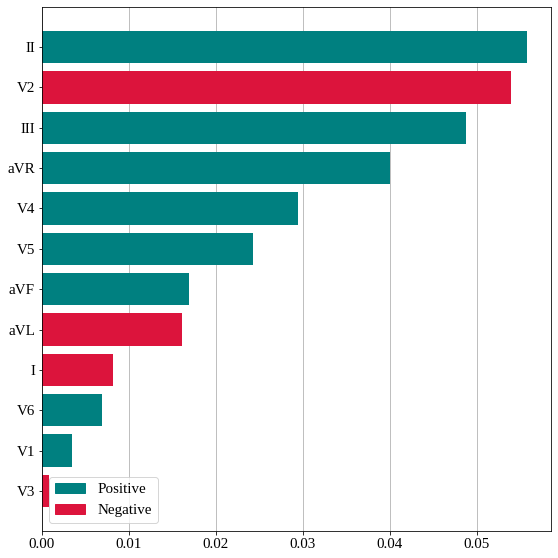

In [39]:
fig = plt.figure(figsize=(8, 8))
imp_df = imp_df.iloc[-24:, :]
plt.barh(imp_df["Features"], imp_df["Absolute Importance"], color=imp_df["Direction"], zorder=2)
plt.grid(axis="x", zorder=1, which="major")
plt.legend([plt.Rectangle((0,0),1,1, color="teal"), plt.Rectangle((0,0),1,1, color="crimson")], ["Positive", "Negative"])
plt.tight_layout()
plt.savefig("drive/MyDrive/absolute_importance_nn.png", dpi=300)
plt.show()

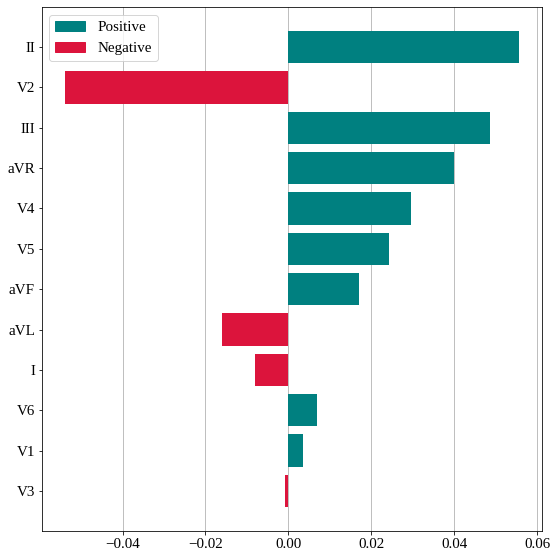

In [40]:
fig = plt.figure(figsize=(8, 8))
imp_df = imp_df.iloc[-24:, :]
plt.barh(imp_df["Features"], imp_df["Importance"], color=imp_df["Direction"], zorder=2)
plt.grid(axis="x", zorder=1, which="major")
plt.legend([plt.Rectangle((0,0),1,1, color="teal"), plt.Rectangle((0,0),1,1, color="crimson")], ["Positive", "Negative"])
plt.tight_layout()
plt.savefig("drive/MyDrive/importance_nn.png", dpi=300)
plt.show()